In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle
import os
import collections

from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, average_precision_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

#import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate
from tensorflow.keras import initializers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from tqdm import tqdm

2023-02-23 18:59:22.905895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 18:59:22.981229: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-23 18:59:22.981250: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-23 18:59:23.445239: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
figure_path = 'model_plots/'

In [3]:
import tensorflow.python.platform.build_info as build
print(build.build_info['cuda_version'])
print(build.build_info['cudnn_version'])
print(tf.__version__)

11.2
8
2.11.0


In [4]:
tf.config.list_physical_devices('GPU')

2023-02-23 18:59:23.888085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 18:59:23.888261: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-23 18:59:23.888306: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-23 18:59:23.888351: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-23 18:59:23.888387: W tensorflow/c

[]

ow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2023-02-23 18:59:23.888453: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-02-23 18:59:23.888485: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2023-02-23 18:59:23.888516: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-02-23 18:59:23.888521: W tensorflow/core/common_runtime/gpu/gpu_device.cc

In [5]:
pd.options.display.max_columns = None

In [6]:
#df_frag = pd.concat(map(pd.read_csv, glob.glob('data/csv_fragmentedV3/*.csv')))


In [7]:
#df = pd.read_csv('data/test/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv')

In [8]:
#df = pd.concat(map(pd.read_csv, glob.glob('data/test/*.csv')))

In [9]:
filename = 'data/preprocessed_data.pickle'

input_file = open(filename, 'rb')
preprocessed_data = pickle.load(input_file)
input_file.close()

In [10]:
le = preprocessed_data['le']
x_train = preprocessed_data['x_train']
y_train = preprocessed_data['y_train']
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']

In [11]:
num_features = x_train.shape[1]

In [12]:
num_features

78

In [13]:
pd.DataFrame(le.classes_, columns=['Type'])

,Type
0,BENIGN
1,PortScan


In [14]:
assert x_train.shape[0] == y_train.shape[0]
assert x_test.shape[0] == y_test.shape[0]
assert x_train.shape[1] == x_test.shape[1]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(243181, 78)
(243181,)
(42915, 78)
(42915,)


In [15]:
# Labels normal data as 0, anomalies as 1

def make_labels_binary(label_encoder, labels):
    normal_data_index = np.where(label_encoder.classes_ == 'BENIGN')[0][0]
    new_labels = labels.copy()
    new_labels[labels != normal_data_index] = 1
    new_labels[labels == normal_data_index] = 0
    return new_labels

In [16]:
y_train = make_labels_binary(le, y_train)
y_test = make_labels_binary(le, y_test)

In [17]:
print(f'Number of anomalies in y_train: {y_train.sum():,}')
print(f'Number of anomalies in y_test: {y_test.sum():,}')

Number of anomalies in y_train: 134,869
Number of anomalies in y_test: 23,935


In [18]:
prev_len = len(x_train)

In [19]:
def subset_normal(x_train, y_train):
    temp_df = x_train.copy()
    temp_df['label'] = y_train
    temp_df = temp_df.loc[temp_df['label'] == 0]
    y_train = temp_df['label'].copy()
    temp_df = temp_df.drop('label', axis = 1)
    x_train = temp_df.copy()
    return x_train,y_train

In [20]:
#Subsetting only Normal Network packets in our training set
x_train, y_train = subset_normal(x_train, y_train)
print(f'Dataset has now the size of {(len(x_train)/prev_len):.2} of the original dataset')

Dataset has now the size of 0.45 of the original dataset


In [21]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(108312, 78)
(108312,)
(42915, 78)
(42915,)


In [22]:
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [23]:
dataset = {}
dataset['x_train'] = x_train.astype(np.float32)
dataset['y_train'] = y_train.astype(np.float32)
dataset['x_test'] = x_test.astype(np.float32)
dataset['y_test'] = y_test.astype(np.float32)

In [24]:
normals = collections.Counter(y_test)[0]
anomalies = collections.Counter(y_test)[1]
anomalies_percentage = anomalies / (normals + anomalies)
print('Number of Normal Network packets in the test set:', normals)
print('Number of Anomalous Network packets in the test set:', anomalies)
print('Ratio of anomalous to normal network packets: ', anomalies_percentage)

Number of Normal Network packets in the test set: 18980
Number of Anomalous Network packets in the test set: 23935
Ratio of anomalous to normal network packets:  0.5577303972969824


In [25]:
def get_generator(optim):
    generator = Sequential()
    generator.add(Dense(64, input_dim=num_features,
                  kernel_initializer=initializers.glorot_normal(seed=32)))
    generator.add(Activation('relu'))

       
    generator.add(Dense(128))
    generator.add(Activation('relu'))
    
    generator.add(Dense(256))
    generator.add(Activation('relu'))
    
    generator.add(Dense(256))
    generator.add(Activation('relu'))
       
    generator.add(Dense(512))
    generator.add(Activation('relu'))
   
    generator.add(Dense(num_features, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optim)

    return generator


def get_discriminator(optim):

    discriminator = Sequential()

    discriminator.add(Dense(256, input_dim=num_features,
                      kernel_initializer=initializers.glorot_normal(seed=32)))
    


    discriminator.add(Dense(128))
    discriminator.add(LeakyReLU())
       
    discriminator.add(Dense(128))
    discriminator.add(LeakyReLU())
    
    discriminator.add(Dense(128))
    discriminator.add(LeakyReLU())

    discriminator.add(Dense(128))
    discriminator.add(LeakyReLU())
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=optim)


    return discriminator

In [26]:
def make_gan_network(discriminator, generator, optim, input_dim=num_features):
    discriminator.trainable = False
    gan_input = Input(shape=(input_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)

    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optim)

    return gan

In [27]:
lr = 0.0002
batch_size = 512
epochs = 50
momentum=0.5
adam = Adam(learning_rate=lr, beta_1=momentum)

In [28]:
# Training the GAN
x_train, y_train, x_test, y_test = dataset['x_train'], dataset['y_train'], dataset['x_test'], dataset['y_test']

In [29]:
# x_train, y_train = x_train[:20], y_train[:20]

In [30]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(108312, 78) (108312,) (42915, 78) (42915,)


In [31]:
# Calculating the number of batches based on the batch size
batch_count = x_train.shape[0] // batch_size
#pbar = tqdm(total=epochs * batch_count, position=0, leave=True)
pbar = tqdm(total=epochs * batch_count, position=0, leave=True)

gan_loss = []
discriminator_loss = []

# Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = make_gan_network(discriminator, generator, adam, input_dim=num_features)

print("Number params: ", gan.count_params())

for epoch in range(epochs):
    for index in range(batch_count):
        pbar.update(1)
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size, num_features])

        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)

        # Obtain a batch of normal network packets
        image_batch = x_train[index * batch_size: (index + 1) * batch_size]

        X = np.vstack((generated_images, image_batch))
        y_dis = np.ones(2*batch_size)
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, num_features])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)

        # Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)

    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" %
          (epoch, index, batch_count, d_loss, g_loss))

  0%|                                                                                                                                                   | 0/10550 [00:00<?, ?it/s]2023-02-23 18:59:24.336641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
  0%|                                                                                                                                           | 1/10550 [00:00<24:46,  7.10it/s]

Number params:  386575


  2%|██▊                                                                                                                                      | 217/10550 [00:05<04:10, 41.26it/s]

Epoch 0 Batch 210/211 [D loss: 0.511573] [G loss:0.901365]


  4%|█████▌                                                                                                                                   | 427/10550 [00:11<04:03, 41.66it/s]

Epoch 1 Batch 210/211 [D loss: 0.419564] [G loss:0.973392]


  6%|████████▎                                                                                                                                | 642/10550 [00:16<03:52, 42.55it/s]

Epoch 2 Batch 210/211 [D loss: 0.224042] [G loss:0.810263]


  8%|███████████                                                                                                                              | 852/10550 [00:21<03:52, 41.73it/s]

Epoch 3 Batch 210/211 [D loss: 0.074240] [G loss:0.316824]


 10%|█████████████▋                                                                                                                          | 1062/10550 [00:26<03:42, 42.70it/s]

Epoch 4 Batch 210/211 [D loss: 0.088138] [G loss:0.561649]


 12%|████████████████▍                                                                                                                       | 1272/10550 [00:31<03:36, 42.79it/s]

Epoch 5 Batch 210/211 [D loss: 0.031706] [G loss:0.153321]


 14%|███████████████████                                                                                                                     | 1482/10550 [00:36<03:31, 42.85it/s]

Epoch 6 Batch 210/211 [D loss: 0.019932] [G loss:0.175367]


 16%|█████████████████████▉                                                                                                                  | 1697/10550 [00:41<03:27, 42.67it/s]

Epoch 7 Batch 210/211 [D loss: 0.085125] [G loss:0.287954]


 18%|████████████████████████▌                                                                                                               | 1907/10550 [00:46<03:22, 42.70it/s]

Epoch 8 Batch 210/211 [D loss: 0.020386] [G loss:0.061424]


 20%|███████████████████████████▎                                                                                                            | 2117/10550 [00:51<03:17, 42.65it/s]

Epoch 9 Batch 210/211 [D loss: 0.018183] [G loss:0.062232]


 22%|█████████████████████████████▉                                                                                                          | 2327/10550 [00:55<03:11, 42.92it/s]

Epoch 10 Batch 210/211 [D loss: 0.017086] [G loss:0.098916]


 24%|████████████████████████████████▋                                                                                                       | 2537/10550 [01:00<03:09, 42.27it/s]

Epoch 11 Batch 210/211 [D loss: 0.020371] [G loss:0.127647]


 26%|███████████████████████████████████▍                                                                                                    | 2752/10550 [01:06<03:02, 42.66it/s]

Epoch 12 Batch 210/211 [D loss: 0.015411] [G loss:0.200445]


 28%|██████████████████████████████████████▏                                                                                                 | 2961/10550 [01:11<03:07, 40.49it/s]

Epoch 13 Batch 210/211 [D loss: 0.012664] [G loss:0.116866]


 30%|████████████████████████████████████████▊                                                                                               | 3170/10550 [01:16<03:05, 39.68it/s]

Epoch 14 Batch 210/211 [D loss: 0.036098] [G loss:0.148445]


 32%|███████████████████████████████████████████▌                                                                                            | 3381/10550 [01:21<03:09, 37.87it/s]

Epoch 15 Batch 210/211 [D loss: 0.022812] [G loss:0.092225]


 34%|██████████████████████████████████████████████▎                                                                                         | 3596/10550 [01:27<02:53, 40.10it/s]

Epoch 16 Batch 210/211 [D loss: 0.015507] [G loss:0.064629]


 36%|█████████████████████████████████████████████████                                                                                       | 3806/10550 [01:32<02:49, 39.73it/s]

Epoch 17 Batch 210/211 [D loss: 0.014814] [G loss:0.111245]


 38%|███████████████████████████████████████████████████▊                                                                                    | 4018/10550 [01:37<02:41, 40.48it/s]

Epoch 18 Batch 210/211 [D loss: 0.789550] [G loss:5.757842]


 40%|██████████████████████████████████████████████████████▍                                                                                 | 4227/10550 [01:42<02:35, 40.57it/s]

Epoch 19 Batch 210/211 [D loss: 0.212704] [G loss:2.591982]


 42%|█████████████████████████████████████████████████████████▏                                                                              | 4440/10550 [01:48<02:32, 39.97it/s]

Epoch 20 Batch 210/211 [D loss: 0.182162] [G loss:1.887971]


 44%|███████████████████████████████████████████████████████████▉                                                                            | 4648/10550 [01:53<02:27, 39.95it/s]

Epoch 21 Batch 210/211 [D loss: 0.084610] [G loss:1.875152]


 46%|██████████████████████████████████████████████████████████████▋                                                                         | 4860/10550 [01:58<02:23, 39.54it/s]

Epoch 22 Batch 210/211 [D loss: 0.047861] [G loss:1.821949]


 48%|█████████████████████████████████████████████████████████████████▎                                                                      | 5069/10550 [02:04<02:16, 40.29it/s]

Epoch 23 Batch 210/211 [D loss: 0.052094] [G loss:1.866671]


 50%|████████████████████████████████████████████████████████████████████                                                                    | 5281/10550 [02:09<02:11, 40.12it/s]

Epoch 24 Batch 210/211 [D loss: 0.053782] [G loss:2.865721]


 52%|██████████████████████████████████████████████████████████████████████▊                                                                 | 5491/10550 [02:14<02:04, 40.49it/s]

Epoch 25 Batch 210/211 [D loss: 0.027826] [G loss:1.850881]


 54%|█████████████████████████████████████████████████████████████████████████▌                                                              | 5704/10550 [02:19<02:01, 39.82it/s]

Epoch 26 Batch 210/211 [D loss: 0.087319] [G loss:4.272746]


 56%|████████████████████████████████████████████████████████████████████████████▎                                                           | 5915/10550 [02:25<01:54, 40.37it/s]

Epoch 27 Batch 210/211 [D loss: 0.011360] [G loss:1.432166]


 58%|██████████████████████████████████████████████████████████████████████████████▉                                                         | 6125/10550 [02:30<01:49, 40.48it/s]

Epoch 28 Batch 210/211 [D loss: 0.012205] [G loss:0.703160]


 60%|█████████████████████████████████████████████████████████████████████████████████▋                                                      | 6339/10550 [02:35<01:43, 40.61it/s]

Epoch 29 Batch 210/211 [D loss: 0.017922] [G loss:0.998370]


 62%|████████████████████████████████████████████████████████████████████████████████████▍                                                   | 6549/10550 [02:40<01:37, 41.24it/s]

Epoch 30 Batch 210/211 [D loss: 0.015494] [G loss:1.213904]


 64%|███████████████████████████████████████████████████████████████████████████████████████▏                                                | 6759/10550 [02:45<01:32, 41.12it/s]

Epoch 31 Batch 210/211 [D loss: 0.013852] [G loss:1.283836]


 66%|█████████████████████████████████████████████████████████████████████████████████████████▊                                              | 6969/10550 [02:50<01:27, 40.77it/s]

Epoch 32 Batch 210/211 [D loss: 0.007967] [G loss:1.630014]


 68%|████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 7179/10550 [02:56<01:23, 40.42it/s]

Epoch 33 Batch 210/211 [D loss: 0.012165] [G loss:1.109452]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7394/10550 [03:01<01:18, 40.45it/s]

Epoch 34 Batch 210/211 [D loss: 0.005169] [G loss:0.596047]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7605/10550 [03:06<01:14, 39.79it/s]

Epoch 35 Batch 210/211 [D loss: 0.043223] [G loss:2.254428]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 7814/10550 [03:11<01:06, 41.22it/s]

Epoch 36 Batch 210/211 [D loss: 0.009114] [G loss:0.826696]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 8024/10550 [03:16<01:01, 40.78it/s]

Epoch 37 Batch 210/211 [D loss: 0.005330] [G loss:0.386240]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 8238/10550 [03:22<00:56, 40.57it/s]

Epoch 38 Batch 210/211 [D loss: 0.004046] [G loss:0.346947]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8448/10550 [03:27<00:51, 40.86it/s]

Epoch 39 Batch 210/211 [D loss: 0.008555] [G loss:1.173231]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8658/10550 [03:32<00:46, 40.61it/s]

Epoch 40 Batch 210/211 [D loss: 0.004752] [G loss:1.589295]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8868/10550 [03:37<00:41, 40.87it/s]

Epoch 41 Batch 210/211 [D loss: 0.005929] [G loss:0.717466]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 9078/10550 [03:42<00:37, 39.18it/s]

Epoch 42 Batch 210/211 [D loss: 0.003657] [G loss:0.915938]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 9289/10550 [03:48<00:32, 39.25it/s]

Epoch 43 Batch 210/211 [D loss: 0.001906] [G loss:0.376941]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9502/10550 [03:53<00:25, 41.82it/s]

Epoch 44 Batch 210/211 [D loss: 0.001738] [G loss:0.224618]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9712/10550 [03:58<00:20, 41.32it/s]

Epoch 45 Batch 210/211 [D loss: 0.002135] [G loss:0.155035]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9922/10550 [04:03<00:14, 42.26it/s]

Epoch 46 Batch 210/211 [D loss: 0.002423] [G loss:0.654582]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 10134/10550 [04:08<00:10, 39.56it/s]

Epoch 47 Batch 210/211 [D loss: 0.001134] [G loss:0.656589]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 10343/10550 [04:13<00:04, 41.82it/s]

Epoch 48 Batch 210/211 [D loss: 0.007381] [G loss:2.714421]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 10548/10550 [04:18<00:00, 42.05it/s]

Epoch 49 Batch 210/211 [D loss: 0.002216] [G loss:1.945352]


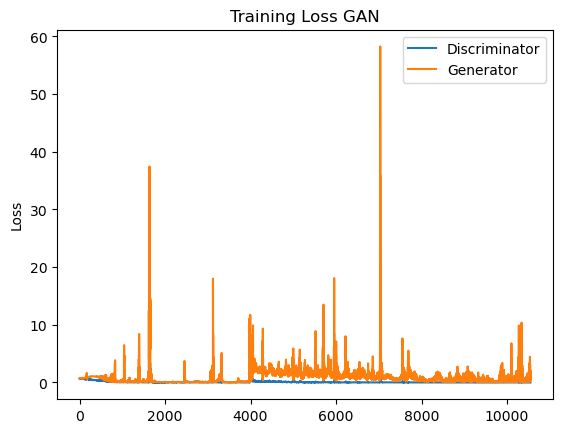

In [32]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Loss GAN")
plt.ylabel('Loss')
plt.legend()
plt.savefig(figure_path + 'loss_gan_only_cic.png')

In [33]:
print(x_test.shape, y_test.shape)

(42915, 78) (42915,)


In [34]:
nr_batches_test = np.ceil(x_test.shape[0] // batch_size).astype(np.int32)

results = []

for t in range(nr_batches_test + 1):
    ran_from = t * batch_size
    ran_to = (t + 1) * batch_size
    image_batch = x_test[ran_from:ran_to]
    tmp_rslt = discriminator.predict(x=image_batch, batch_size=128, verbose=0)
    results = np.append(results, tmp_rslt)

In [35]:
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results), pd.DataFrame(y_test)], axis=1)
results_df.columns = ['results', 'y_test']
print('Mean score for normal packets :',
      results_df.loc[results_df['y_test'] == 0, 'results'].mean())
print('Mean score for anomalous packets :',
      results_df.loc[results_df['y_test'] == 1, 'results'].mean())

Mean score for normal packets : 0.9950404702265638
Mean score for anomalous packets : 0.6795699983280438


## Plots

In [36]:
def plot_confusion_matrix(cm, savefile, name, cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix ' + name)
    plt.colorbar()
    plt.xticks(np.arange(2), ['Normal','Anomaly'], rotation=45)
    plt.yticks(np.arange(2), ['Normal','Anomaly'])
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(savefile)

def plot_accuracy(history, savefile, name):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['accuracy', 'val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy in percent')
    plt.title(name)
    plt.savefig(savefile)
    
def plot_loss(history, savefile, name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(name)
    plt.savefig(savefile)
    
def plot_roc(tpr, fpr, roc_auc, savefile, name):
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, lw=1, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lime', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC ' + name)
    plt.legend(loc="lower right")
    plt.savefig(savefile)


## Thresholds

In [37]:
anomalies_percentage

0.5577303972969824

In [38]:
# Obtaining the lowest "anomalies_percentage" score
per = np.percentile(results, anomalies_percentage*100)
y_pred = results.copy()
y_pred = np.array(y_pred)

In [39]:
# Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary')
print('Accuracy Score :', accuracy_score(y_test, y_pred))
print('Precision :', precision)
print('Recall :', recall)
print('F1 :', f1)

Accuracy Score : 0.9810322730979844
Precision : 0.9829956131188636
Recall : 0.9829956131188636
F1 : 0.9829956131188636


In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_curve = auc(fpr, tpr)

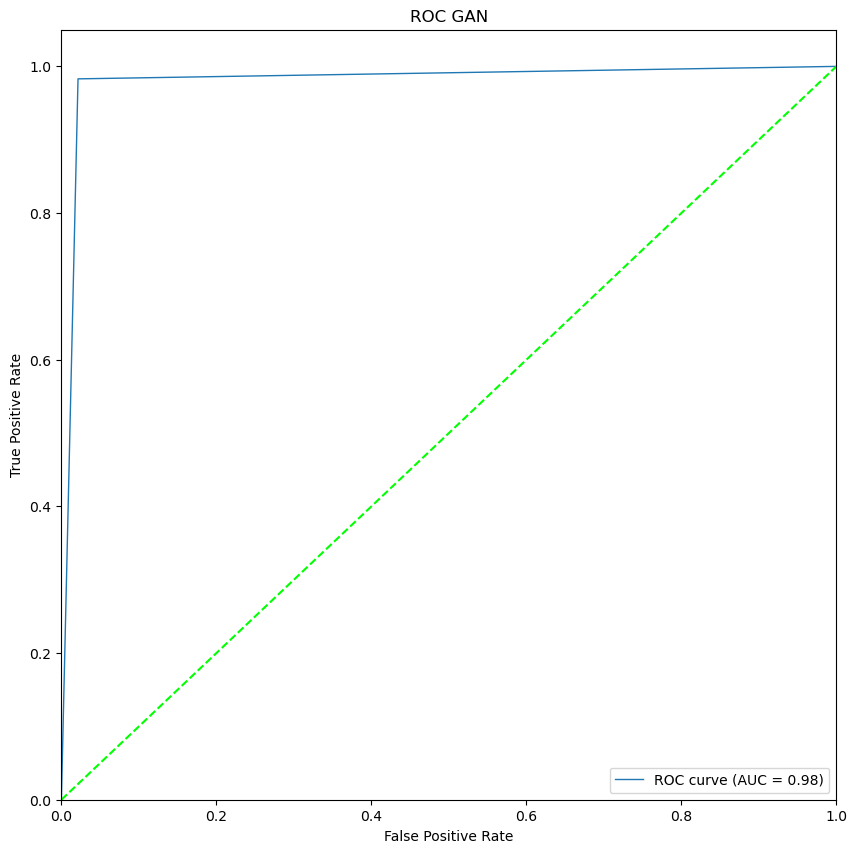

In [41]:
plot_roc(tpr, fpr, auc_curve, figure_path + 'roc_gan_only_cic.png', 'GAN')

In [42]:
cm = confusion_matrix(y_test, y_pred)

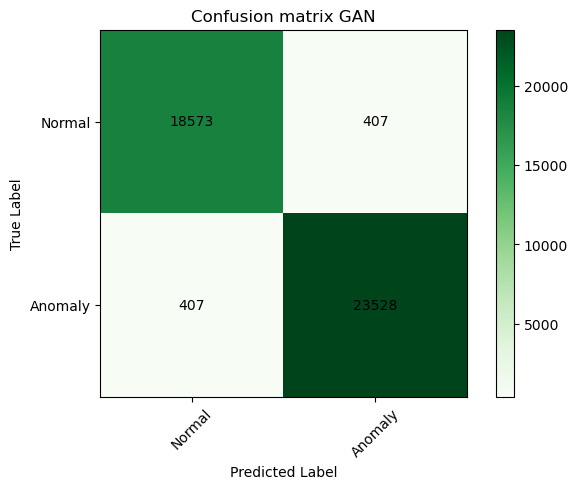

In [43]:
plot_confusion_matrix(cm, figure_path + 'confusion_gan_only_cic.png', 'GAN')

In [44]:
model = Sequential()
model.add(Dense(256, input_shape=(num_features,), activation="sigmoid"))
model.add(Dense(128, activation="sigmoid"))
model.add(Dense(1, activation="sigmoid"))
sgd = Adam()
model.compile(loss="categorical_crossentropy", optimizer=sgd,
metrics=["accuracy"])
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=512)


Epoch 1/10
212/212 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9953 - val_loss: 0.0000e+00 - val_accuracy: 0.4423
Epoch 2/10
212/212 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.4423
Epoch 3/10
212/212 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.4423
Epoch 4/10
212/212 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.4423
Epoch 5/10
212/212 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.4423
Epoch 6/10
212/212 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.4423
Epoch 7/10
212/212 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10550/10550 [04:30<00:00, 42.05it/s]